# Mean Shift


Centers of clusters:
 [[2.95568966 1.95775862]
 [7.20690909 2.20836364]
 [2.17603774 8.03283019]
 [5.97960784 8.39078431]
 [4.99466667 4.65844444]]

Number of clusters in input data = 5


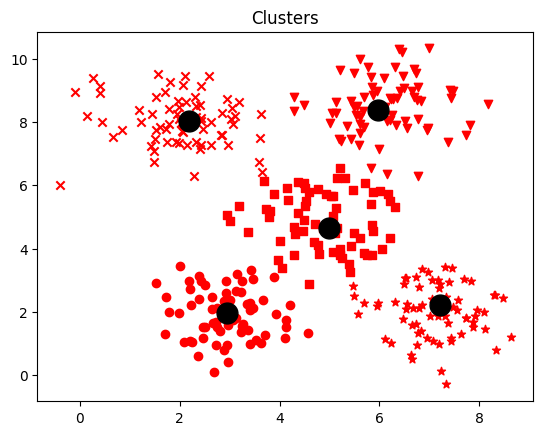

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth
from itertools import cycle

# Load data from input file
X = np.loadtxt('data_clustering.txt', delimiter=',')

# Estimate the bandwidth of X
bandwidth_X = estimate_bandwidth(X, quantile=0.1, n_samples=len(X))

# Cluster data with MeanShift
meanshift_model = MeanShift(bandwidth=bandwidth_X, bin_seeding=True)
meanshift_model.fit(X)

# Extract the centers of clusters
cluster_centers = meanshift_model.cluster_centers_
print('\nCenters of clusters:\n', cluster_centers)

# Estimate the number of clusters
labels = meanshift_model.labels_
num_clusters = len(np.unique(labels))
print("\nNumber of clusters in input data =", num_clusters)

# Plot the points and cluster centers
plt.figure()
markers = 'o*xvs'
for i, marker in zip(range(num_clusters), markers):
    # Plot points that belong to the current cluster
    plt.scatter(X[labels==i, 0], X[labels==i, 1], marker=marker, color='r')

    # Plot the cluster center
    cluster_center = cluster_centers[i]
    plt.plot(cluster_center[0], cluster_center[1], marker='o', 
            markerfacecolor='black', markeredgecolor='black', 
            markersize=15)

plt.title('Clusters')
plt.show()


# Mall Customers

Estimated number of clusters using Mean Shift: 5


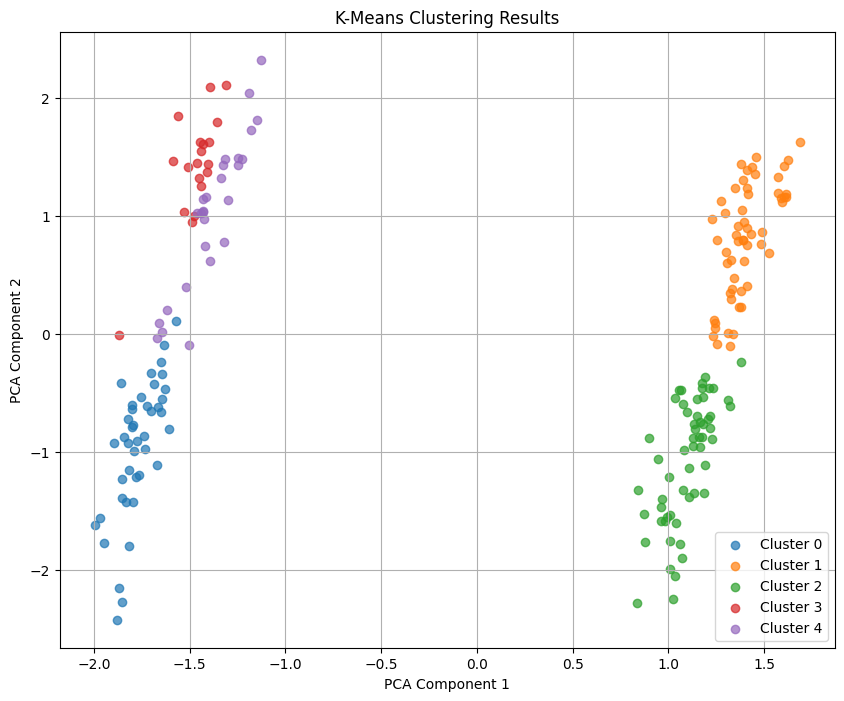

Cluster Centers (Age, Annual Income (k$), Spending Score (1-100), Gender Female, Gender Male):
[[ 5.29285714e+01  6.02380952e+01  3.13571429e+01  3.33066907e-16
   1.00000000e+00]
 [ 2.83928571e+01  6.04285714e+01  6.81785714e+01  1.00000000e+00
  -4.44089210e-16]
 [ 4.78035714e+01  5.80714286e+01  3.48750000e+01  1.00000000e+00
  -4.44089210e-16]
 [ 3.32105263e+01  8.97368421e+01  7.92631579e+01  0.00000000e+00
   1.00000000e+00]
 [ 2.40370370e+01  4.59629630e+01  5.35555556e+01  2.22044605e-16
   1.00000000e+00]]

Cluster 0:

     Age  Annual Income (k$)  Spending Score (1-100) Gender
8     64                  19                       3   Male
10    67                  19                      14   Male
14    37                  20                      13   Male
18    52                  23                      29   Male
30    60                  30                       4   Male
32    53                  33                       4   Male
42    48                  39                  

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, KMeans, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA

data = pd.read_csv('Mall_Customers.csv')

# Encode the "Gender" column using one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
gender_encoded = encoder.fit_transform(data[['Gender']])

X = np.concatenate((data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values, gender_encoded), axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use Mean Shift to determine the number of clusters
bandwidth = estimate_bandwidth(X_scaled, quantile=0.1, n_samples=len(X_scaled))
meanshift = MeanShift(bandwidth=bandwidth)
meanshift.fit(X_scaled)

# Determine the number of clusters based on Mean Shift
n_clusters = len(np.unique(meanshift.labels_))
print(f"Estimated number of clusters using Mean Shift: {n_clusters}")

# Perform K-Means clustering with the estimated number of clusters
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans.fit(X_scaled)

# Add cluster labels to the original dataset
data['Cluster'] = kmeans.labels_

# Reduce dimensionality for visualization (you can skip this if you prefer not to visualize)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
data['PCA1'] = X_pca[:, 0]
data['PCA2'] = X_pca[:, 1]

# Visualize the clusters using a scatter plot (2D PCA projection)
plt.figure(figsize=(10, 8))
for cluster in range(n_clusters):
    plt.scatter(data[data['Cluster'] == cluster]['PCA1'],
                data[data['Cluster'] == cluster]['PCA2'],
                label=f'Cluster {cluster}', alpha=0.7)

plt.title('K-Means Clustering Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

# Print cluster centroids
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
print('Cluster Centers (Age, Annual Income (k$), Spending Score (1-100), Gender Female, Gender Male):')
print(cluster_centers)

# Organize the data by clusters
clustered_data = []
for cluster in range(5):
    cluster_data = data[data['Cluster'] == cluster].copy()
    clustered_data.append(cluster_data)

# Display data in each cluster
for cluster, cluster_data in enumerate(clustered_data):
    print(f'\nCluster {cluster}:\n')
    print(cluster_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender']])


# AP Model

In [13]:
import datetime
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import GraphicalLassoCV
from sklearn import cluster
import yfinance as yf

# Input file containing company symbols
input_file = 'company_symbol_mapping.json'

# Load the company symbol map
with open(input_file, 'r') as f:
    company_symbols_map = json.loads(f.read())

symbols, names = np.array(list(company_symbols_map.items())).T

# Load the historical stock quotes
start_date = "2021-01-01"
end_date = "2021-12-31"

# Initialize lists to store opening and closing quotes
opening_quotes = []
closing_quotes = []
dates = None

# Fetch historical data for each stock symbol
valid_symbols = []  # Store symbols with valid data
for symbol in symbols:
    data = yf.Ticker(symbol).history(start=start_date, end=end_date)
    
    if data.empty or len(data) < 2:
        continue
    
    # Extract dates if not already extracted
    if dates is None:
        dates = data.index
    
    # Check if the data aligns with existing dates
    if not np.array_equal(dates, data.index):
        continue

    opening_quotes.append(data["Open"].values)
    closing_quotes.append(data["Close"].values)
    valid_symbols.append(symbol)

# Convert lists to NumPy arrays
opening_quotes = np.array(opening_quotes)
closing_quotes = np.array(closing_quotes)

# Compute differences between opening and closing quotes
quotes_diff = closing_quotes - opening_quotes

# Normalize the data
X = quotes_diff.T
X = np.nan_to_num(X)  # Replace NaN with 0 (you can choose another value if needed)

# Create a graph model (GraphicalLassoCV)
edge_model = GraphicalLassoCV()

# Train the model
with np.errstate(invalid='ignore'):
    edge_model.fit(X)

# Build clustering model using Affinity Propagation model
_, labels = cluster.affinity_propagation(edge_model.covariance_)

# Ensure that labels match the valid symbols
matched_labels = np.zeros(len(symbols), dtype=int) - 1
for i, symbol in enumerate(symbols):
    if symbol in valid_symbols:
        matched_labels[i] = labels[valid_symbols.index(symbol)]

# Filter symbols and labels to match common indices
symbols = symbols[matched_labels >= 0]
labels = matched_labels[matched_labels >= 0]

# Print the results of clustering
num_labels = labels.max()
print('\nClustering of stocks based on difference in opening and closing quotes:\n')
for i in range(num_labels + 1):
    cluster_symbols = symbols[labels == i]
    print("Cluster", i+1, "==>", ', '.join(cluster_symbols))


$NAV: possibly delisted; no timezone found



Clustering of stocks based on difference in opening and closing quotes:

Cluster 1 ==> MSFT, AMZN, AAPL
Cluster 2 ==> F
Cluster 3 ==> IBM, NOC, BA, KO, MMM, MCD, PEP, K, PG
